Adapted from is from https://github.com/vschaik/Active-Inference

In [14]:
import numpy as np
import torch
from matplotlib import pyplot as plt

In [15]:
np.random.seed(123)
torch.manual_seed(123);

In [16]:
def sensory_dynamics(psi):
    """
    P(s | psi)
    Probability of experiencing sensory state 1 given current position.
    """
    return MAX_SENSE_PROBABILITY * torch.exp(-SENSE_DECAY_RATE * 
                torch.min(torch.abs(psi - FOOD_POSITION), torch.abs(psi - FOOD_POSITION - ENV_SIZE)))


def model_encoding(b):
    """
    Probability of occupying specific position as encoded in the internal state.
    """
    # Softmax function. The shift by b.max() is for numerical stability
    return torch.exp(b - b.max()) / torch.sum(torch.exp(b - b.max()))


def generative_density(b, a):
    """
    P(psi', s | b, a)
    Agent's prediction of its new position given its internal state and selected action
    (calculated separately for two sensory states).

    P(psi', s | b, a) = Sum_over_psi(P(psi' | s, b, a, psi) * P(s | b, a, psi) * P(psi | b, a))
                      = Sum_over_psi(P(psi' | a, psi) * P(s | psi) * P(psi | b))
                      
    since psi' only depends on a and psi, s only depends on psi, and psi only depends on b.

    """
    # sensory dynamics for each position: 
    """P(s | psi)"""
    sd = sensory_dynamics(torch.arange(ENV_SIZE))
    
    """
    P(psi', s | b, a) = Sum_over_psi(P(psi' | a, psi) * P(s | psi) * P(psi | b))
    Note that the Sum_over_psi is only taken over the two positions psi that can result in getting to psi' given a
    """
    psi_prime_0 = ((1-MOVEMENT_PROBABILITY) * (1 - sd) * model_encoding(b) + 
                 MOVEMENT_PROBABILITY * torch.roll((1 - sd) * model_encoding(b), a))

    psi_prime_1 = ((1-MOVEMENT_PROBABILITY) * sd * model_encoding(b) + 
                 MOVEMENT_PROBABILITY * torch.roll(sd * model_encoding(b), a))
    
    return [psi_prime_0, psi_prime_1]


def variational_density(b):
    """
    P(psi | b)
    Agent's belief about the external states (i.e. its current position in the 
    world) or intention (i.e. desired position in the world) as encoded in the
    internal state.
    """
    return model_encoding(b)


def KL(a, b):
    """
    Kullback-Leibler divergence between densities a and b.
    """
    return torch.sum(a * (torch.log(a) - torch.log(b)))


def free_energy(b_star, b, s, a):
    """
    KL divergence between variational density and generative density for a fixed
    sensory state s.
    """
    return KL(variational_density(b_star), generative_density(b, a)[s])

In [17]:
def simulate_agent(psi, b, b_star):
    """
    Simulate the agent for EPOCHS steps.
    """
    # start trace at initial position
    psi_trace = [psi]
    
    # show the sensory dynamics given the food distribution at the left of the belief trace
    b_trace = [sensory_dynamics(torch.arange(ENV_SIZE)).numpy()]
    
    s_trace = []
    
    a_trace = []

    for epoch in range(EPOCHS):

        # Calculate sensory state s \in {0, 1}
        s = int(np.random.random() < sensory_dynamics(torch.tensor([psi, ])).item())

        # Pick action state, a \in {-1, 0, 1}
        # Calculate the free energy given my target (intent) distribution, current state distribution, & sensory input 
        # Do this for all (three) actions and select the action with minimum free energy.
        i = np.argmin((free_energy(b_star, b, s, -1).item(), 
                       free_energy(b_star, b, s, 0).item(), 
                       free_energy(b_star, b, s, 1).item()))
        a = (-1, 0, 1)[i]

        # Update actual position by taking action
        psi = (psi + a * (np.random.random() < MOVEMENT_PROBABILITY)) % ENV_SIZE
            
        # Update my internal state.
        # Start by creating a belief for my new position b_prime, from my belief for my previous position b
        # by mixing according to movement probability given action a:
        b_prime = MOVEMENT_PROBABILITY * torch.roll(b, a) + (1 - MOVEMENT_PROBABILITY) * b
        # Note, this is not essential, as the minimisation below will update b_prime,
        # but it does provide a good starting point for gradient descent
        
        b.requires_grad = True
        
        b_prime = torch.nn.Parameter(b_prime)
        
        opt = torch.optim.Adam([b_prime, ], lr=LEARNING_RATE)
        # Now minimise free energy
        for step in range(N_STEPS):
            opt.zero_grad()
            loss = free_energy(b_prime, b, s, a)
            loss.backward()
            opt.step()
            
        # Update internal state
        b = b_prime.detach()
        
        # Save position, sensory output, and internal state for plotting
        s_trace.append(s)
        a_trace.append(a)
        psi_trace.append(psi)
        b_trace.append(model_encoding(b).numpy())

    # Show the target position as probability distribution at the right of the belief trace
    b_trace.append(model_encoding(b_star).numpy()) 
    s_trace.append(int(np.random.random() < sensory_dynamics(torch.tensor([psi,])).item()))
    return (b_trace, psi_trace, s_trace, a_trace)


def plot_traces(b_trace, psi_trace, s_trace, a_trace):
    """
    Helper function for plotting agent's internal state and position.
    """
    fig = plt.figure(figsize=(15, 4))
    ax = fig.gca()
    im = ax.imshow(np.transpose(b_trace),
              interpolation="nearest", 
              aspect = "auto", 
              vmin = 0, vmax = 1, 
              cmap = "viridis")
    c = np.asarray(['white' if s==1 else 'grey' for s in s_trace])
    psi = np.asarray(psi_trace)
    epochs = np.arange(EPOCHS+1)
    a_trace.append(0)
    a = np.asarray(a_trace)
    idx = a<0
    ax.scatter(epochs[idx], psi[idx], c = c[idx], marker = 'v')
    idx = a>0
    ax.scatter(epochs[idx], psi[idx], c = c[idx], marker = '^')
    idx = a==0
    ax.scatter(epochs[idx], psi[idx], c = c[idx], marker = 'o')    
    ax.invert_yaxis()
    ax.set_xlim([0,EPOCHS+1])
    fig.colorbar(im)
    return fig

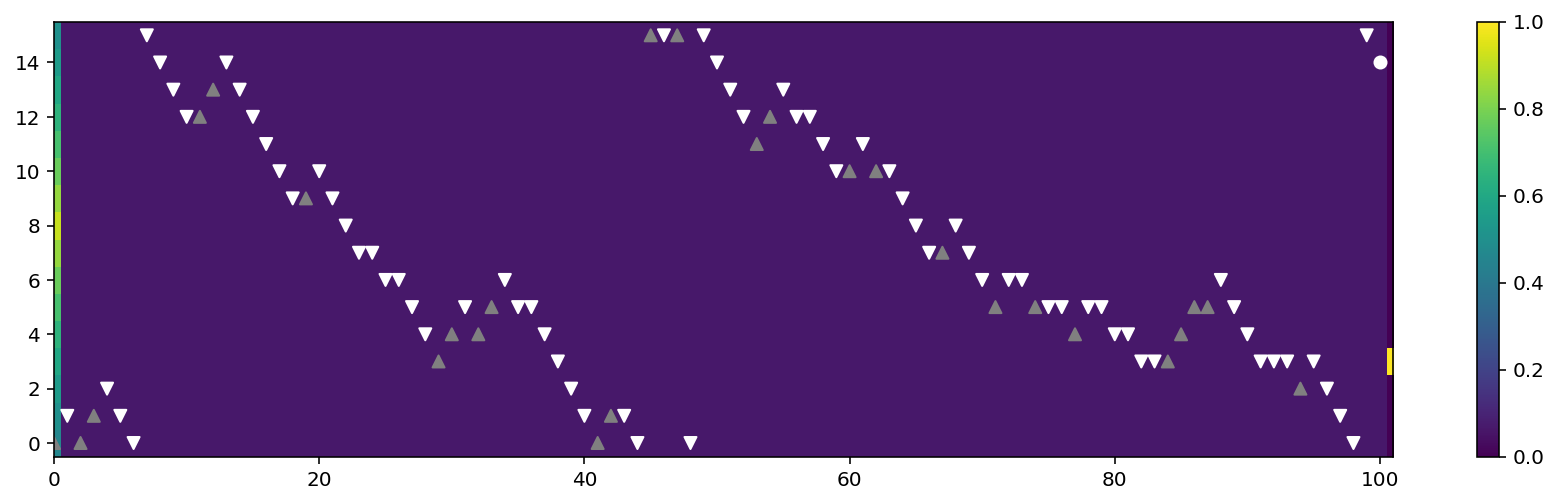

In [18]:
ENV_SIZE = 16
INITIAL_POSITION = 0
FOOD_POSITION = 8
MOVEMENT_PROBABILITY = 0.75

# Sensory dynamics parameters
MAX_SENSE_PROBABILITY = 4.0**(-1.0/16) # k
SENSE_DECAY_RATE = np.log(4)/16 # omega

# Position (external state), Psi \in (0,15)
psi = INITIAL_POSITION

# Internal state, R \in R^16
b = torch.zeros(ENV_SIZE, requires_grad=False)

# Internal state (as intention), Ri \in R^16
TARGET_POSITION = 3
b_star = torch.zeros(ENV_SIZE)
b_star[TARGET_POSITION] = 10 # strong preference for a single target position

# Simulation parameters
EPOCHS = 100                 # Number of epochs (simulation steps).
N_STEPS = 100                # Number of gradient descent steps made to update beliefs in each epoch.
LEARNING_RATE = 0.7          # Stochastic gradient descent learning rate

# Run simulation
(b_trace, psi_trace, s_trace, a_trace) = simulate_agent(psi, b, b_star)

# Plot output
fig = plot_traces(b_trace, psi_trace, s_trace, a_trace)

# # Print sensory spike probability as a function of position
# print(sensory_dynamics(np.arange(ENV_SIZE)))